In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Thin Lens

In [2]:
#Solves for the system matrix
def A_gen(f):
    return np.array([[1, -1/f],[0, 1]])

#Computes the image distance and height using the system matrix
def images(A,do,ho):
    di = (-A[1,0] + A[1,1]*do)/(A[0,0] - A[0,1]*do)
    M = 1 / (A[0,0] - A[0,1]*do)
    hi = M*ho
    return di,hi

#Computes the solve of a given line
def slope(xo,yo,xi,yi):
    return (yi -yo)/(xi -xo)

#Creates a line given two points
def my_line(m, x0, y0, x):
    return m * (x - x0) + y0

#Creates a line given a point and an angle
def lines(x,a,y0,x0):
    return np.tan(a)*(x-x0) + y0

def T(d,n): #Transfer matrix
    return np.array([[1.,0.],[d/n,1.]])

In [3]:
#Solves the intersection of two curves
def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

In [4]:
def thin_lens_expander(so,ho,f,f2,d,a0,n,n_index): 
    if n_index < 1: f,f2 = -f,-f2
    
    #Calculate the image distance and image height
    si,hi = images(A_gen(f),so,ho)   
   
    plt.figure(figsize=(18,12))
    plt.axvline(x=0, linestyle='-', color='k', label='first lens') #lens1
    plt.axhline(y=0, linestyle='-', color='k') 
    plt.plot(-f,0, 'bo') #focus
    plt.plot(f,0, 'bo') #focus
    #plt.vlines(x=so, ymin = 0, ymax=ho, linewidth=3, color='r', label="object" ) #object
    #plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label="image") #image

    for i in np.linspace(0,1,n): #loop sa number of rays
        plt.hlines(y=i*ho, xmin = so, xmax=0, linewidth=1,linestyles='--', color='r') #first ray
        plt.plot(np.linspace(0,si), my_line(slope(0,i*ho,f,0), 0,i*ho, np.linspace(0,si)), 'r--', linewidth=1) #second ray
        
        ray1x = np.linspace(so,0)
        ray1y = lines(ray1x,a0,i*ho,so)

        line1y = np.linspace(-20,20)
        line1x = np.linspace(0,0)

        p1x,p1y  = intersection(line1x,line1y,ray1x,ray1y)

        plt.plot(np.linspace(so,0), my_line(slope(0,i*hi,so,i*ho), so, i*ho,np.linspace(so,0)), 'b--', linewidth=1)
        #plt.plot(ray1x,ray1y, 'y--', linewidth=1) #second ray
        #plt.plot([p1x[0],si],[p1y[0],i*hi], 'y--', linewidth=1) #connects intersection of ray and lens to image
        plt.hlines(y=i*hi, xmin = 0, xmax=si, linewidth=1,linestyles='--', color='b') 


    if f2 != 0 and d != 0:     
        si2,hi2 = images(A_gen(f2),si-d,hi) 
        si2 = -si2
        plt.axvline(x=d, linestyle='-', color='g', label='second lens') #lens2
        plt.plot(d+f2,0, 'ko') #focus
        plt.plot(d-f2,0, 'ko') #focus
        #plt.vlines(x=d+si2, ymin = 0, ymax=hi2, linewidth=3, color='k', label="image2") #image

        for i in np.linspace(0,1,n):
            #plt.hlines(y=i*hi, xmin = si, xmax=d, linewidth=1,linestyles='--', color='y') #first ray
            #plt.plot(np.linspace(d,d+si2), my_line(slope(d,i*hi,d+f2,0), d,i*hi, np.linspace(d,d+si2)), 'y--', linewidth=1) #second ray
            
            ray2x = np.linspace(d,si)
            ray2y = lines(ray2x,a0,i*hi,si)

            line2y = np.linspace(-20,20)
            line2x = np.linspace(d,d)

            p2x,p2y  = intersection(line2x,line2y,ray2x,ray2y)

            #plt.plot(ray2x,ray2y, 'm--', linewidth=1) #second ray
            #plt.plot([p2x[0],d+si2],[p2y[0],i*hi2], 'm--', linewidth=1) #second ray

            plt.plot(np.linspace(si,d), my_line(slope(si,i*hi, d-f2,0), d, i*hi2,np.linspace(si,d)), 'g--', linewidth=1)
            plt.hlines(y=i*hi2, xmin = d, xmax=d+si2, linewidth=1,linestyles='--', color='g')
        
    
    if f2 != 0 and d != 0: plt.title('Double Lens System', fontsize = '20')
    else: plt.title('Single Lens System', fontsize = '20')
    ho = -ho
    a0 = -a0
    #Calculate the image distance and image height
    si,hi = images(A_gen(f),so,ho)   
   
    plt.axvline(x=0, linestyle='-', color='k') #lens1
    plt.axhline(y=0, linestyle='-', color='k') 
    plt.plot(-f,0, 'bo') #focus
    plt.plot(f,0, 'bo') #focus
    #plt.vlines(x=so, ymin = 0, ymax=ho, linewidth=3, color='r', label="object" ) #object
    #plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label="image") #image

    for i in np.linspace(0,1,n): #loop sa number of rays
        plt.hlines(y=i*ho, xmin = so, xmax=0, linewidth=1,linestyles='--', color='r') #first ray
        plt.plot(np.linspace(0,si), my_line(slope(0,i*ho,f,0), 0,i*ho, np.linspace(0,si)), 'r--', linewidth=1) #second ray
        
        ray1x = np.linspace(so,0)
        ray1y = lines(ray1x,a0,i*ho,so)

        line1y = np.linspace(-20,20)
        line1x = np.linspace(0,0)

        p1x,p1y  = intersection(line1x,line1y,ray1x,ray1y)

        plt.plot(np.linspace(so,0), my_line(slope(0,i*hi,so,i*ho), so, i*ho,np.linspace(so,0)), 'b--', linewidth=1)
        #plt.plot(ray1x,ray1y, 'y--', linewidth=1) #second ray
        #plt.plot([p1x[0],si],[p1y[0],i*hi], 'y--', linewidth=1) #connects intersection of ray and lens to image
        plt.hlines(y=i*hi, xmin = 0, xmax=si, linewidth=1,linestyles='--', color='b') 


    if f2 != 0 and d != 0:     
        si2,hi2 = images(A_gen(f2),si-d,hi) 
        si2 = -si2
        plt.axvline(x=d, linestyle='-', color='g') #lens2
        plt.plot(d+f2,0, 'ko') #focus
        plt.plot(d-f2,0, 'ko') #focus
        #plt.vlines(x=d+si2, ymin = 0, ymax=hi2, linewidth=3, color='k', label="image2") #image

        for i in np.linspace(0,1,n):
            #plt.hlines(y=i*hi, xmin = si, xmax=d, linewidth=1,linestyles='--', color='y') #first ray
            #plt.plot(np.linspace(d,d+si2), my_line(slope(d,i*hi,d+f2,0), d,i*hi, np.linspace(d,d+si2)), 'y--', linewidth=1) #second ray
            
            ray2x = np.linspace(d,si)
            ray2y = lines(ray2x,a0,i*hi,si)

            line2y = np.linspace(-20,20)
            line2x = np.linspace(d,d)

            p2x,p2y  = intersection(line2x,line2y,ray2x,ray2y)

            #plt.plot(ray2x,ray2y, 'm--', linewidth=1) #second ray
            #plt.plot([p2x[0],d+si2],[p2y[0],i*hi2], 'm--', linewidth=1) #second ray

            plt.plot(np.linspace(si,d), my_line(slope(si,i*hi, d-f2,0), d, i*hi2,np.linspace(si,d)), 'g--', linewidth=1)
            plt.hlines(y=i*hi2, xmin = d, xmax=d+si2, linewidth=1,linestyles='--', color='g')
            
    plt.legend()
    plt.savefig('beam_expander.png')
    plt.xlim(so,si2)
    plt.show()

Case 3: Beam Expander


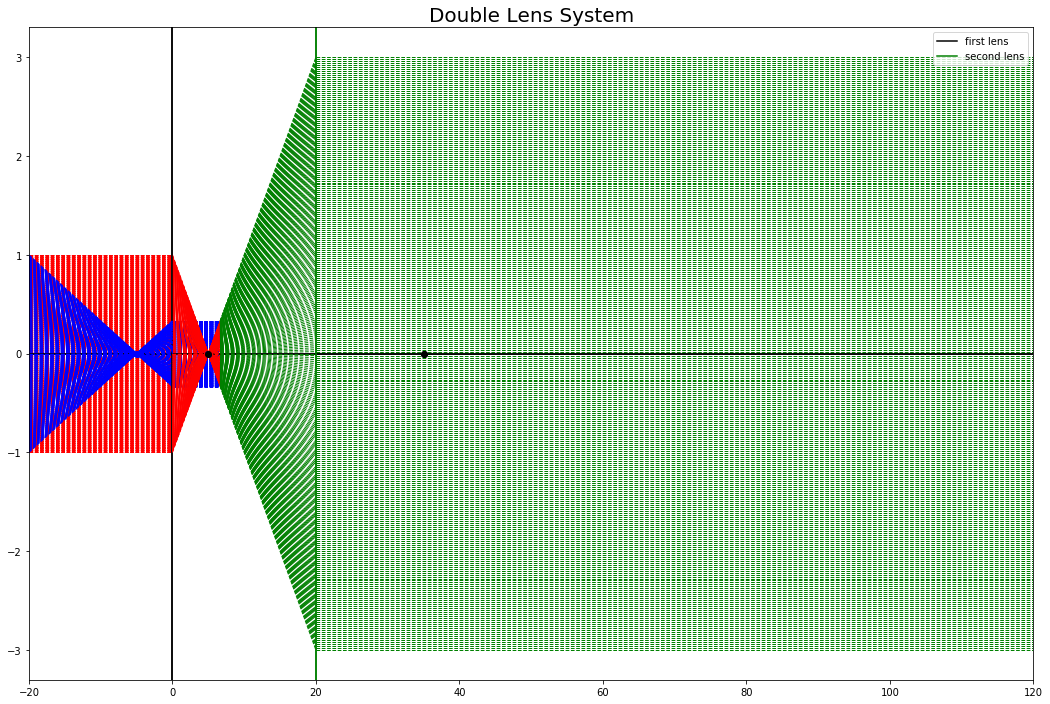

In [5]:
so,ho,f,f2,d,a0,n,n_index = -20,1,5,15,20,np.radians(5),150, 1.5
print('Case 3: Beam Expander')
thin_lens_expander(so,ho,f,f2,d,a0,n,n_index)

In [16]:
def thin_lens_microscope(so,ho,f,f2,d,a0,n,n_index): 
    if n_index < 1: f,f2 = -f,-f2
    
    #Calculate the image distance and image height
    si,hi = images(A_gen(f),so,ho)   
   
    plt.figure(figsize=(18,12))
    plt.axvline(x=0, linestyle='-', color='k', label='first lens') #lens1
    plt.axhline(y=0, linestyle='-', color='k') 
    plt.plot(-f,0, 'bo') #focus
    plt.plot(f,0, 'bo') #focus
    if f2 == 0 and d == 0: plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label=" final image")
    if f2 != 0 and d != 0: plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label=" intermediate image") #image

    for i in np.linspace(0,1,n): #loop sa number of rays
        plt.hlines(y=i*ho, xmin = so, xmax=0, linewidth=1,linestyles='--', color='b') #first ray
        plt.plot(np.linspace(0,si), my_line(slope(0,i*ho,f,0), 0,i*ho, np.linspace(0,si)), 'b--', linewidth=1) #second ray
        
        ray1x = np.linspace(so,0)
        ray1y = lines(ray1x,a0,i*ho,so)

        line1y = np.linspace(-20,20)
        line1x = np.linspace(0,0)

        p1x,p1y  = intersection(line1x,line1y,ray1x,ray1y)

        plt.plot(np.linspace(so,0), my_line(slope(0,i*hi,so,i*ho), so, i*ho,np.linspace(so,0)), 'b--', linewidth=1)
        plt.plot(ray1x,ray1y, 'b--', linewidth=1) #second ray
        plt.plot([p1x[0],si],[p1y[0],i*hi], 'b--', linewidth=1) #connects intersection of ray and lens to image
        plt.hlines(y=i*hi, xmin = 0, xmax=si, linewidth=1,linestyles='--', color='b') 


    if f2 != 0 and d != 0:     
        si2,hi2 = images(A_gen(f2),si-d,hi) 
        plt.axvline(x=d, linestyle='-', color='g', label='second lens') #lens2
        plt.plot(d+f2,0, 'ko') #focus
        plt.plot(d-f2,0, 'ko') #focus


        for i in np.linspace(0,1,n):
            plt.hlines(y=i*hi, xmin = si, xmax=d, linewidth=1,linestyles='--', color='r') #first ray
            plt.plot(np.linspace(d,d+si2), my_line(slope(d,i*hi,d+f2,0), d,i*hi, np.linspace(d,d+si2)), 'r--', linewidth=1) #second ray
            
            ray2x = np.linspace(d,si)
            ray2y = lines(ray2x,a0,i*hi,si)

            line2y = np.linspace(-20,20)
            line2x = np.linspace(d,d)

            p2x,p2y  = intersection(line2x,line2y,ray2x,ray2y)

            plt.plot(ray2x,ray2y, 'r--', linewidth=1) #second ray
            plt.plot([p2x[0],d+si2],[p2y[0],i*hi2], 'r--', linewidth=1) #second ray

            plt.plot(np.linspace(si,d), my_line(slope(si,i*hi, d-f2,0), d, i*hi2,np.linspace(si,d)), 'r--', linewidth=1)
            plt.hlines(y=i*hi2, xmin = d, xmax=d+si2, linewidth=1,linestyles='--', color='r')
        
        plt.vlines(x=d+si2, ymin = 0, ymax=hi2, linewidth=3, color='k', label="final image") #image
    plt.vlines(x=so, ymin = 0, ymax=ho, linewidth=3, color='r', label="object" ) #object
    plt.legend()
    if f2 != 0 and d != 0: plt.title('Double Lens System', fontsize = '20')
    else: plt.title('Single Lens System', fontsize = '20')

    plt.savefig('microscope.png', bbox_inches = 'tight')
    plt.show()

Case 1: Microscope


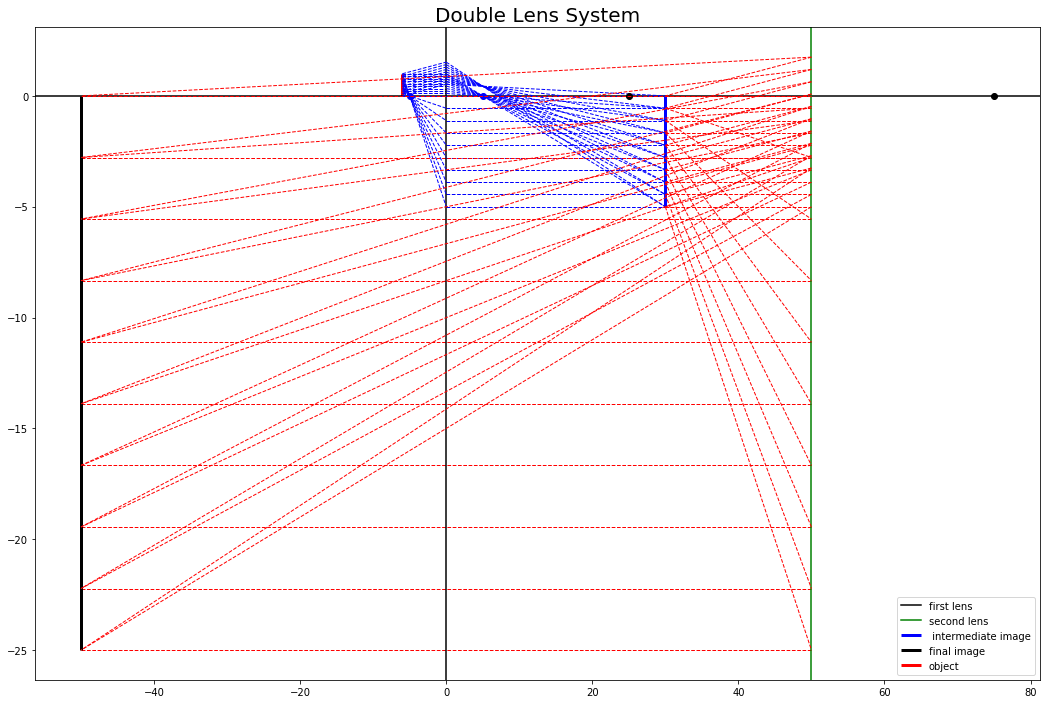

In [17]:
so,ho,f,f2,d,a0,n,n_index = -6,1,5,25,50,np.radians(5),10, 1.5
print('Case 1: Microscope')
thin_lens_microscope(so,ho,f,f2,d,a0,n,n_index)

In [14]:
def thin_lens_lens_media(so,ho,f,f2,d,a0,n,n_index): 
    if n_index < 1: f,f2 = -f,-f2
    
    #Calculate the image distance and image height
    si,hi = images(A_gen(f),so,ho)   
   
    plt.figure(figsize=(18,12))
    plt.axvline(x=0, linestyle='-', color='k', label='lens') #lens1
    plt.axhline(y=0, linestyle='-', color='k') 
    plt.plot(-f,0, 'bo') #focus
    plt.plot(f,0, 'bo') #focus
    if f2 == 0 and d == 0: plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label=" final image")
    if f2 != 0 and d != 0: plt.vlines(x=si, ymin = 0, ymax=hi, linewidth=3, color='b', label=" intermediate image") #image

    for i in np.linspace(0,1,n): #loop sa number of rays
        plt.hlines(y=i*ho, xmin = so, xmax=0, linewidth=1,linestyles='--', color='b') #first ray
        plt.plot(np.linspace(0,si), my_line(slope(0,i*ho,f,0), 0,i*ho, np.linspace(0,si)), 'b--', linewidth=1) #second ray
        
        ray1x = np.linspace(so,0)
        ray1y = lines(ray1x,a0,i*ho,so)

        line1y = np.linspace(-20,20)
        line1x = np.linspace(0,0)

        p1x,p1y  = intersection(line1x,line1y,ray1x,ray1y)

        plt.plot(np.linspace(so,0), my_line(slope(0,i*hi,so,i*ho), so, i*ho,np.linspace(so,0)), 'b--', linewidth=1)
        plt.plot(ray1x,ray1y, 'b--', linewidth=1) #second ray
        plt.plot([p1x[0],si],[p1y[0],i*hi], 'b--', linewidth=1) #connects intersection of ray and lens to image
        plt.hlines(y=i*hi, xmin = 0, xmax=si, linewidth=1,linestyles='--', color='b') 


    if f2 != 0 and d != 0:     
        si2,hi2 = images(A_gen(f2),si-d,hi) 
        plt.axvline(x=d, linestyle='-', color='g', label='second lens') #lens2
        plt.plot(d+f2,0, 'ko') #focus
        plt.plot(d-f2,0, 'ko') #focus


        for i in np.linspace(0,1,n):
            plt.hlines(y=i*hi, xmin = si, xmax=d, linewidth=1,linestyles='--', color='r') #first ray
            plt.plot(np.linspace(d,d+si2), my_line(slope(d,i*hi,d+f2,0), d,i*hi, np.linspace(d,d+si2)), 'r--', linewidth=1) #second ray
            
            ray2x = np.linspace(d,si)
            ray2y = lines(ray2x,a0,i*hi,si)

            line2y = np.linspace(-20,20)
            line2x = np.linspace(d,d)

            p2x,p2y  = intersection(line2x,line2y,ray2x,ray2y)

            plt.plot(ray2x,ray2y, 'r--', linewidth=1) #second ray
            plt.plot([p2x[0],d+si2],[p2y[0],i*hi2], 'r--', linewidth=1) #second ray

            plt.plot(np.linspace(si,d), my_line(slope(si,i*hi, d-f2,0), d, i*hi2,np.linspace(si,d)), 'r--', linewidth=1)
            plt.hlines(y=i*hi2, xmin = d, xmax=d+si2, linewidth=1,linestyles='--', color='r')
        
        plt.vlines(x=d+si2, ymin = 0, ymax=hi2, linewidth=3, color='k', label="final image") #image
    plt.vlines(x=so, ymin = 0, ymax=ho, linewidth=3, color='r', label="object" ) #object
    plt.legend()
    if f2 != 0 and d != 0: plt.title('Double Lens System', fontsize = '20')
    else: plt.title('Single Lens System', fontsize = '20')

    plt.savefig('lenslessmedia.png', bbox_inches = 'tight')
    plt.show()

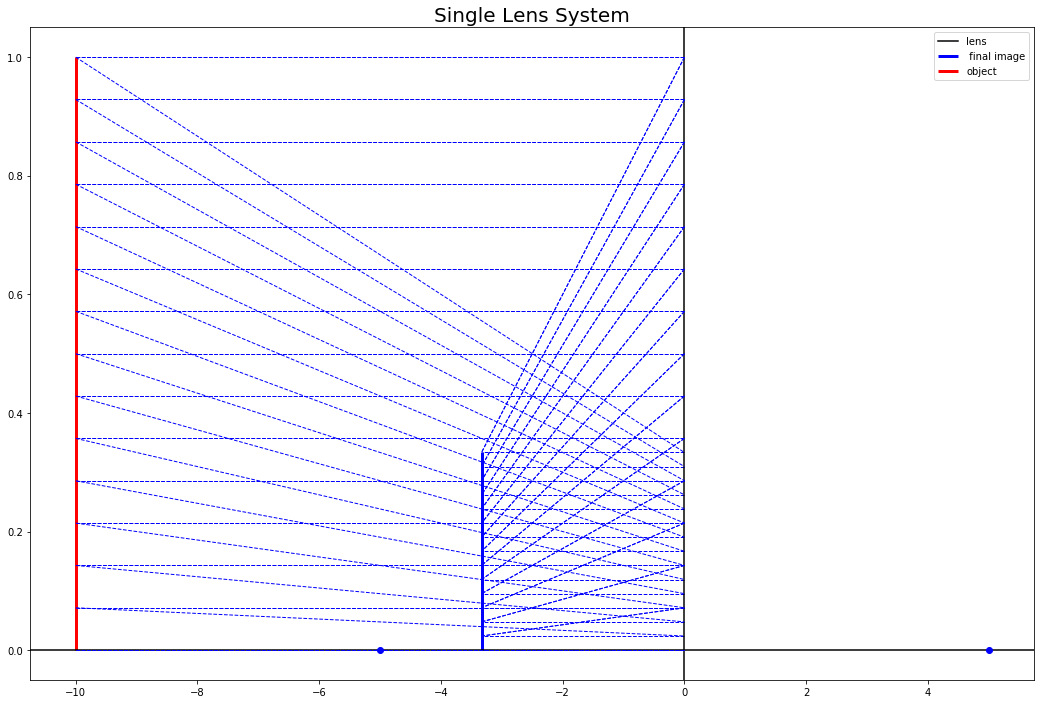

In [15]:
so,ho,f,f2,d,a0,n,n_index = -10, 1,-5,0,0,0,15, 1.5
thin_lens_lens_media(so,ho,f,f2,d,a0,n,n_index)